# Text classification :: Spam detection


## Task 

We want to build a Spam detector which, given examples of spam emails (e.g. flagged by users) and examples of regular (non-spam, also called "ham") emails, learns how to flag new unseen emails as spam or non-spam.

## Data

We will use the [SpamAssassin](https://spamassassin.apache.org/) public email corpus$^*$. This dataset contains ~6'000 labeled emails with a ~30% spam ratio. If you want to learn more about this dataset, check [this](https://spamassassin.apache.org/old/publiccorpus/).  

The dataset has been downloaded for you and is available in the *data* folder.

## Summary

1. Load the data
2. Text preprocessing
3. Data exploration
4. Feature extraction
5. Build a spam detector
6. What did our model learn? Error analysis

$^*$ *Datasets of text are called corpora and samples are called documents.*

## 1. The data

In [1]:
# Load libraries and helper functions

import tools

In [2]:
# Load the data

df = tools.load_data()

Data loaded.
Data size: (5832, 2)


Let's have a look at a few rows from the dataset.

***Note:*** *label* is 0 for *non-spam* and 1 for *spam*.

In [3]:
df.sample(3)

,label,text
3642,0,"On Wed, 4 Sep 2002, Tom wrote: > A groys gesheft zol er hobn mit shroyre vus er hot, zol men bay im nit > fregn, un vos men fregt zol er nisht hobn, and if that aint the truth > nutin is. A nice curse. Don't get ""shroyre"", though."
3083,0,"Neale Pickett <neale@woozle.org> writes: > Skip Montanaro <skip@pobox.com> writes: > > > Yes. It also seems to me that web page content filtering proxies (you > > know, keeping your kids or employees from visiting XXX websites) would > > be another good application of the technology. > > Not to mention IDS (Intrusion Detection Systems). > > IANAS but I have a friend who is, and he's suggested to me a few times > that it would be very interesting and possibly fruitful to apply > Bayesian analysis to network security. But I think I'm going to have to > pull out the probab/stats book from college before I embark on such a > thing :) I have half a mind to see how it works as a replacement for gnus' adaptive scoring. A harder problem than spam filtering, I guess, but it might be interesting. Cheers, M. _______________________________________________ Spambayes mailing list Spambayes@python.org http://mail.python.org/mailman/listinfo/spambayes"
4248,0,"URL: http://scriptingnews.userland.com/backissues/2002/09/25#aProductiveThread Date: Thu, 26 Sep 2002 00:18:04 GMT ""rssflowersalignright""A productive thread[1] on RSS-DEV confronts the negativeness about RSS 2.0[2] head-on. This will go someplace interesting. I left a big hint there in the way the blogChannel module[3] is designed, patterned after the Syndication module[4] designed by the RDF folk. In other words, the place where they're expressing discomfort with RSS 2.0 is where they can make it their own. Lead. Instead of feeling disempowered, be powerful. At one point I saw clearly where the compromise between RSS 0.9x and 1.0 was. We could have gotten there in early 2001, so instead we get there in late 2002. So what, not a big deal. Think about how much better it will be _when we're all advocating the same format._ Visualize peace. That's basically what I did when I did the 2.0 spec. I know it's hard to swallow, but swallow anyway. If I did it, you can too. [1] http://groups.yahoo.com/group/rss-dev/message/4032 [2] http://backend.userland.com/rss [3] http://backend.userland.com/blogChannelModule [4] http://web.resource.org/rss/1.0/modules/syndication/"


Now, let's check the number of samples per class in the data.

Samples per class (%):
non-spam    70.3
spam        29.7
Name: label, dtype: float64




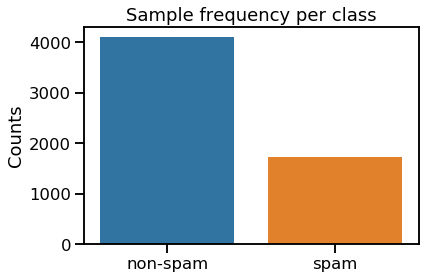

In [4]:
tools.plot_class_frequency(df)

## 2. Text preprocessing

Good text preprocessing is an essential part of every NLP project!

Our goal here is to build a model that distinguishes non-spam from spam. The idea here is to "clean" and "standardize" raw text before feeding it to our machine learning model. We need to keep as many "informative" words as possible, while discarding the "uniformative" ones. Removing unnecessary content, i.e. the "noise", from our texts will help to improve the accuracy of our models.

**Take a few minutes to look at the raw text. What do you think should be removed from the text?**

Below are a few pointers:

* HTML tags 
* URLs
* E-mail addresses
* Punctuation marks, digits (e.g. 2002, 1.1, ...)
* Multiple whitespace
* Case conversion (e.g. Dog vs dog, ...)
* English STOPWORDS (e.g. a, is, my, i, all, and, by...)
* ...

The *clean_corpus* function below takes care of all of that!

In [5]:
df = tools.clean_corpus(df)

print('Data cleaned.')

Data cleaned.


Let's have a look at a few "cleaned" examples.

In [6]:
tools.show_clean_text(df)


Original document:

URL: http://boingboing.net/#85516609 Date: Not supplied Here's a brief interview with me. *Interviewer:* If the Boing Boing zine and blog were TV characters, who'd they be, and how'd they get on? *Mark:* The zine would be Jethro Bodine of "The Beverly Hillbillies" -- curious, neophilic, xenophilic, gleeful, and eager to adopt any new theory or conspiracy as the absolute truth. The Blog would be Sherman from "Peabody's Improbable History" -- a traveler of time and space in search of beauty, truth, and the outre. I think Jethro bOING bOING and Sherman Boing Boing would be great pals. Jethro would invite Sherman's dog, Mr. Peabody, to go raccoon hunting with him, and Sherman would send Jethro 40 years into the future to hang out at the Playboy Mansion. Link[1] Discuss[2] [1] http://www.octapod.org/jeanpoole/archives/000203.html#000203 [2] http://www.quicktopic.com/16/H/kymC9LzuB2bHM

Cleaned document:

0    date supplied heres brief interview interviewer boing boing z

## 3. Data Exploration :: What makes spam distinct?

### 2.1 Frequent words

Which words distinguish spam from non-spam? Can we  identify the words in a text that are the most informative about its topic?

Let's find the most frequent words in spam and non-spam.

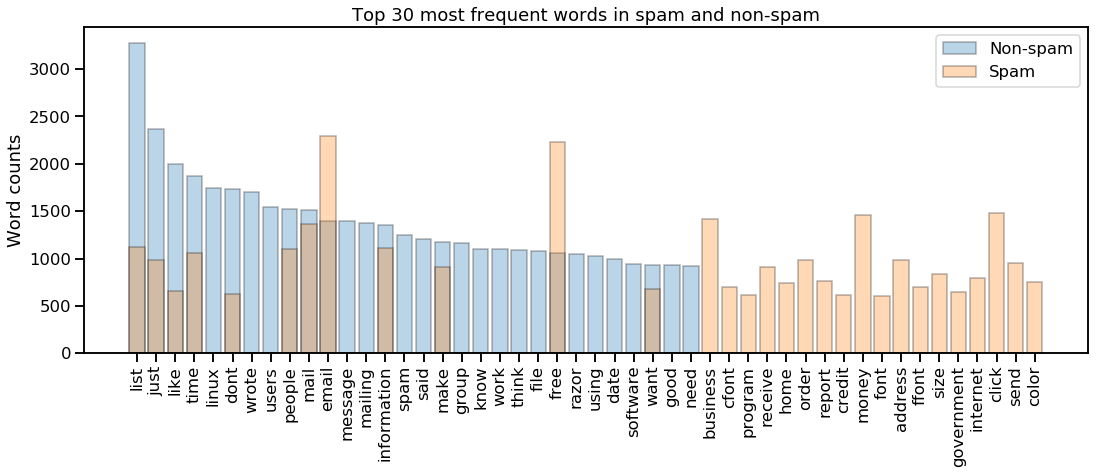

In [7]:
tools.plot_most_common_words(df=df, N=30)

**Frequent "spammish" words**: 

* click
* money
* business
* free
* email
* ...

**Frequent "non-spammish" words**:
* list
* linux
* message
* wrote
* users
* spam
* said
* file
* good
* ...

### 2.2 What about "spammish" signatures?

* Do spams contain more HTML tags? 
* Does non-spam contain more URLs and E-mail adresses? 
* Are spams mails longer than non-spam? 
* ...

Let's find out!

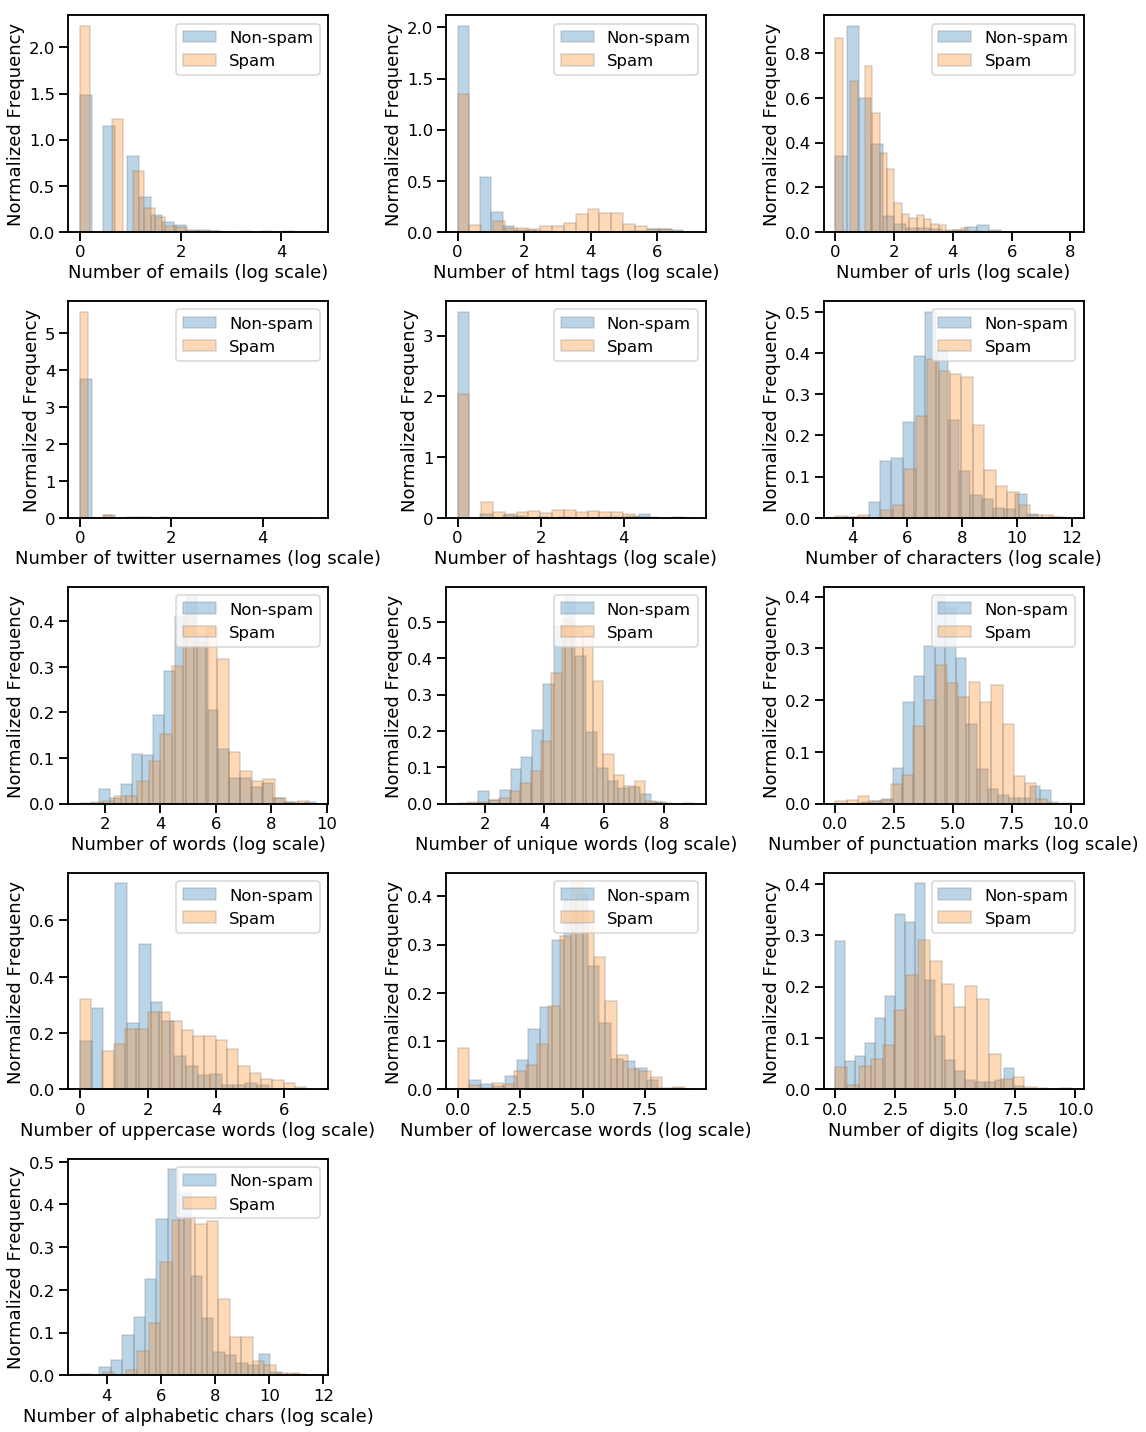

In [8]:
features = tools.get_features(df=df)

## 3. Feature engineering :: Extracting features from text

Computers don't understand natural language. So, how do we represent text?

One of the simplest but effective and commonly used models to represent text for machine learning is the ***Bag of Words*** model ([online documentation](https://en.wikipedia.org/wiki/Bag-of-words_model)). When using this model, we discard most of the structure of the input text (word order, chapters, paragraphs, sentences and formating) and only count how often each word appears in each text. Discarding the structure and counting only word occurencies leads to the mental image of representing text as a "bag".  

**Example:** Let our toy corpus contain just four documents.

In [9]:
tools.show_bag_of_words_vector()

,captain,deep,enjoy,i,learning,like,my,nlp,o,paragliding
Text,,,,,,,,,,
I enjoy paragliding.,0,0,1,1,0,0,0,0,0,1
I like NLP.,0,0,0,1,0,1,0,1,0,0
I like deep learning.,0,1,0,1,1,1,0,0,0,0
O Captain! my Captain!,2,0,0,0,0,0,1,0,1,0


Bag of Words has converted all documents into numeric vectors. Each column represents a word from the corpus and each row one of the four documents. The value in each cell represents the number of times that word appears in a specific document. For example, the fourth document has the word `captain` occuring twice and the words `my` and `O` occuring once.

## 4. Build a spam detector

In the previous section, we saw how to perform text preprocessing and feature extraction from text. We are now ready to build our machine learning model for detecting spams. We will use a Logistic Regression classifier ([online documentation](https://en.wikipedia.org/wiki/Logistic_regression)).

First, we need to split the data into two sets: the `train` set and the `test` set. We will then use the train set to `fit` our model. The test set will be used to `evaluate` the performance of our model. 

### 4.1 Spam classification

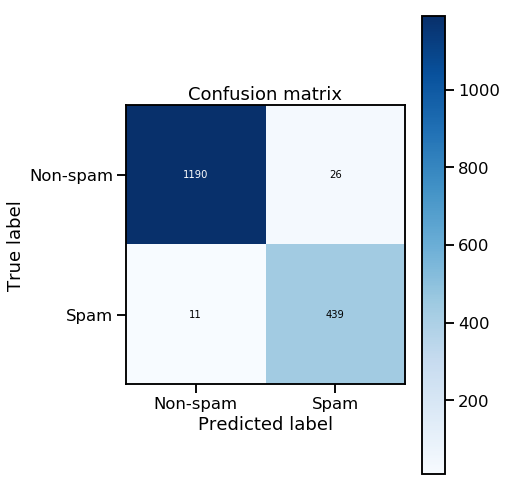

In [10]:
# Train/test splitting
# --------------------
df_train, df_test = tools.train_test_split_(df)

# Fit model on the train data
# ---------------------------
model = tools.fit_model(df_train)

# Print results
# -------------
tools.plot_confusion_matrix(df_test,model);

**Confusion matrices**  

Confusion matrices are a nice way of evaluating the performance of models for classification models. Rows correspond to the true classes and the columns to the predicted classes. Entries on the main diagonal of the confusion matrix correspond to correct predictions while the other cells tell us how many mistakes made our model ([online documentation]((https://en.wikipedia.org/wiki/Confusion_matrix))).

* The first row represents non-spam mails: 1'190 were correctly classified as 'non-spam', while 26 (~2%) were misclassified as 'spam'.
* The second row represents spam mails: 439 were correctly classified as 'spam', while 11  (~2,4%) were misclassified as 'non-spam'.

Our model did quite well!

### 4.2 What did our model learn from the data?

Our logistic regression model has learned which words are the most indicative of non-spam and which words are the most indicative of spam. The positive coefficients on the right correspond to words that, according to the model, are indicative of spam. The negative coefficients on the left correspond to words that, according to the model, are indicative of non-spam.

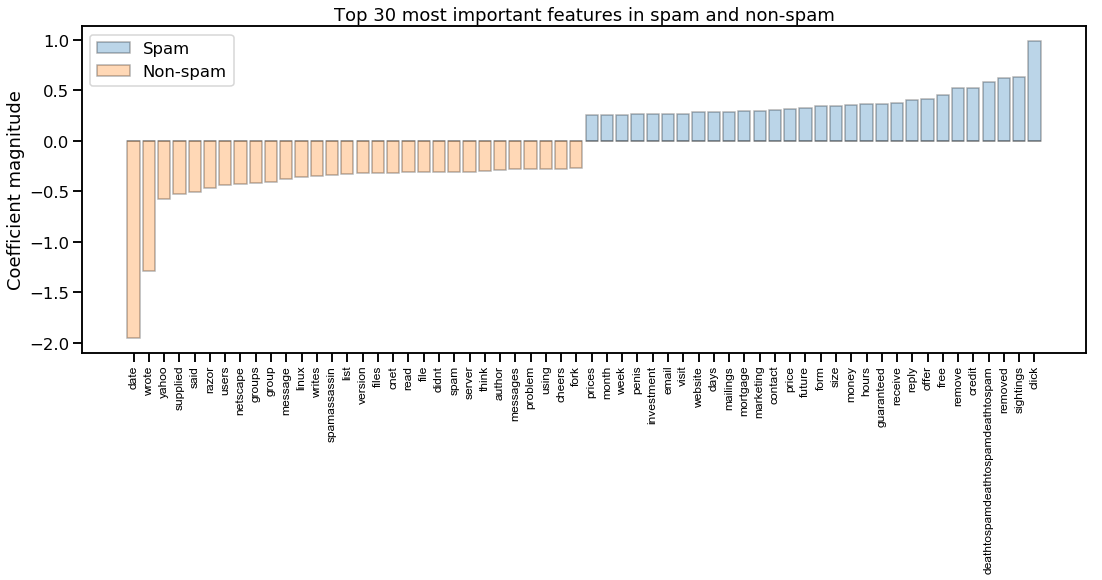

In [11]:
tools.visualize_coefficients(model, n_top_features=30)

According to the model, words such as "date", "wrote", "yahoo", "said", "linux", "author", ... are strong indicators of non-spam.  

Words such as "click", "credit", "remove", "free", "offer", "money" ... indicate spam. 

### 4.3 Error analysis :: Where does our model fail?

We will now analyze the misclassified mails in order to get some insights on where the model failed to make correct predictions. The *error_analysis* function below will show us the top features responsible for the model making a decision of prediction whether the mail is spam or non-spam.

Document index: 14 


Original Text
You are receiving this email because you signed up to receive one of our free reports. If you would prefer not to receive messages of this type, please unsubscribe by following the instructions at the bottom of this message. Dear Investor, Thank you again for requesting our free special report, "The One Stock that Keeps Wall Street BUZZING." We began The Motley Fool in 1993 with the idea that investors like you deserved better. Better than Wall Street's all-too-often biased research... Better than analysts who speak in "secret codes" allowing them to hedge or spin any recommendation... and better than what passes for "full financial disclosure" in big business today. Given a level playing field, we believe that regular folks -- like us, and you -- can do quite well in the stock market. Why put trust in conflicted information from others when you could count on your own abilities, and potentially blow the pros away? More than two million people visit 

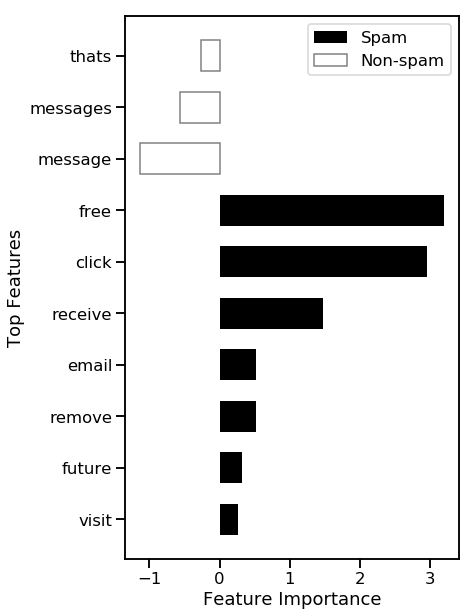

In [12]:
tools.error_analysis(df_test,model,doc_nbr=14)